In [2]:
#First out imports
#Lets import some stuff!
from datetime import datetime, date
import os
import tempfile

from boto.s3.connection import S3Connection
import cartopy
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
# import metpy.calc as mpcalc
# from metpy.plots import simple_layout, StationPlot, StationPlotLayout
# from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from netCDF4 import num2date
import netCDF4
import numpy as np
import pyart
import pytz
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

%matplotlib inline

ImportError: No module named 'boto'

In [2]:
#Helper function for the search

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [4]:
### Lets grab one day of the April 2017 volume from Maryland

# uncomment and alter these and dateRange to acquire a range of dates

# start_dt = date(2017, 4, 1)
# end_dt = date(2017, 7, 1)
# dateRange = pd.date_range(pd.datetime.today(), periods=100).tolist()

my_datetime = datetime(2017,4,1)
station = 'KLWX'
radar = get_radar_from_aws(station, my_datetime)
radar

In [5]:
# Lets get some geographical context
lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)

sweep = 0
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])
pacific = pytz.timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

min_lat: 34.84665020609599  min_lon: -82.8026514575902  max_lat: 43.10556775434826  max_lon: -72.17261672278568
Friday March 31 at 05:02 PM PDT


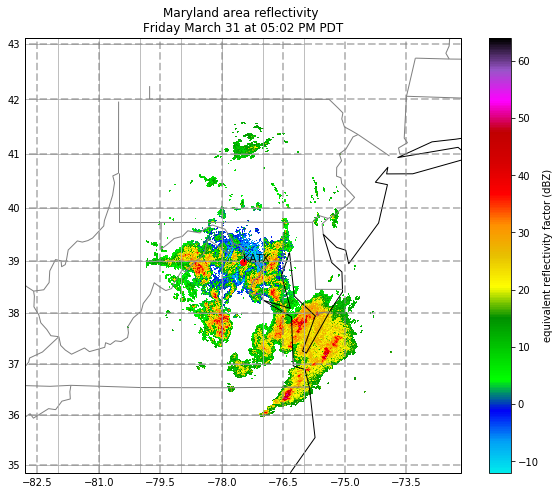

In [6]:
fig = plt.figure(figsize = [10,8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

title = 'Maryland area reflectivity \n' + fancy_date_string

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-12, vmax=64)

# Mark the radar
display.plot_point(lon_0, lat_0, label_text='KATX')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

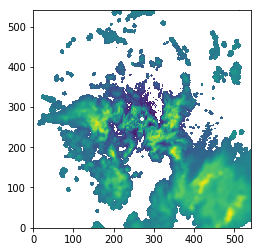

In [15]:


# mask out last 10 gates of each ray, this removes the "ring" around th radar.
radar.fields['reflectivity']['data'][:, -10:] = np.ma.masked

# exclude masked gates from the gridding
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')

# perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    (radar,), gatefilters=(gatefilter, ),
    grid_shape=(1, 541, 541),
    grid_limits=((2000, 2000), (-223000.0, 223000.0), (-223000.0, 223000.0)),
    fields=['reflectivity'])

# create the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(grid.fields['reflectivity']['data'][0], origin='lower')
plt.show()

In [22]:
# write out to geotiff (broken because gdal wont install via pip, using conda or apt-get libgdal-dev would fix, but don't have permissions)
pyart.io.write_grid_geotiff(grid, "grid_geotiff", grid.fields['reflectivity'])

MissingOptionalDependency: GDAL not detected, GeoTIFF output failure!

In [31]:
# next step, pull out dimensions and manually write to shapefile
flatfile = np.array(grid.fields['reflectivity']['data'][0], grid.fields['reflectivity']['lat'], grid.fields['reflectivity']['lon'])


KeyError: 'lat'

In [46]:
print(grid.fields['reflectivity']['data'][0][:])

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


In [48]:
import gdal

ImportError: No module named 'gdal'